## SETUP

### Mount drive storage

In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [ ]:
!nvidia-smi

Thu Oct 27 06:58:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download datasets

In [ ]:
%cd /gdrive/MyDrive/AI-HCM

/gdrive/.shortcut-targets-by-id/1xsCSYNX8m-R6YuUExgx0G3vtWAmcC6s1/AI-HCM


### Setting CLIP model

In [ ]:
!pip install git+https://github.com/openai/CLIP.git &>/dev/null

## PIPELINE

In [ ]:
import os 
import numpy as np

from tqdm import tqdm
from PIL import Image

import torch
import clip

IMAGE_KEYFRAME_PATH = "./Keyframes/Batch"
VISUAL_FEATURES_PATH = "./CLIP_features/Batch"

### Text Embedding

In [ ]:
class TextEmbedding():
  def __init__(self):
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model, _ = clip.load("ViT-B/16", device=self.device)

  def __call__(self, text: str) -> np.ndarray:
    text_inputs = clip.tokenize([text]).to(self.device)
    with torch.no_grad():
        text_feature = self.model.encode_text(text_inputs)[0]
    
    return text_feature.detach().cpu().numpy()
  

# ==================================
text = "A car is parked on the road"
text_embedd = TextEmbedding()
text_feat_arr = text_embedd(text)
print(text_feat_arr.shape, type(text_feat_arr))

100%|███████████████████████████████████████| 335M/335M [00:06<00:00, 53.3MiB/s]


(512,) <class 'numpy.ndarray'>


### Translator

In [ ]:
!pip install git+https://github.com/neuml/txtai#egg=txtai[pipeline]
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neuml/txtai to /tmp/pip-install-kgl1ji7d/txtai_585466ec5c9a4a768cd2d735ffc372e2
  Running command git clone -q https://github.com/neuml/txtai /tmp/pip-install-kgl1ji7d/txtai_585466ec5c9a4a768cd2d735ffc372e2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 5.3 MB 4.7 MB/s 
     |████████████████████████████████| 8.6 MB 57.9 MB/s 
     |████████████████████████████████| 1.3 MB 60.2 MB/s 
     |████████████████████████████████| 68 kB 7.5 MB/s 
     |████████████████████████████████| 548 kB 71.7 MB/s 
     |████████████████████████████████| 128 kB 76.9 MB/s 
     |████████████████████████████████| 296 kB 77.1 MB/s 
     |████████████████████████████████| 13.1 MB 56.3 MB/s 
     |████████████████████████████████| 308 kB 73.4 MB/s 
     |█████████████

In [ ]:
from txtai.pipeline import Translation
translate = Translation()

In [ ]:
def translator(text):
  return translate(text, "en")

### Indexing

In [ ]:
from typing import List, Tuple
def indexing_methods() -> List[Tuple[str, int, np.ndarray],]:
  db = []
  '''Duyệt tuần tự và đọc các features vector từ file .npy'''
  for feat_npy in tqdm(os.listdir(VISUAL_FEATURES_PATH)):
    video_name = feat_npy.split('.')[0]
    feats_arr = np.load(os.path.join(VISUAL_FEATURES_PATH, feat_npy))
    for idx, feat in enumerate(feats_arr):
      '''Lưu mỗi records với 3 trường thông tin là video_name, keyframe_id, feature_of_keyframes'''
      instance = (video_name, idx, feat)
      db.append(instance)
  return db


# ==================================
visual_features_db = indexing_methods()
print()
print(visual_features_db[0][:2], visual_features_db[0][-1].shape)

100%|██████████| 300/300 [00:03<00:00, 76.35it/s] 


('C00_V0110', 0) (512,)


### Search engine

In [ ]:
def append_six(num):
  s = str(num)
  while len(s) < 6: s = "0" + s

  return s

In [ ]:
def search_engine(query_arr: np.array, 
                  db: list, 
                  topk:int=10, 
                  measure_method: str="dot_product") -> List[dict,]:
  
  '''Duyệt tuyến tính và tính độ tương đồng giữa 2 vector'''
  measure = []
  for ins_id, instance in enumerate(db):
    video_name, idx, feat_arr = instance

    if measure_method=="dot_product":
      distance = query_arr @ feat_arr.T
    elif measure_method=="l1_norm":
      distance = -1 * np.mean([abs(q - t) for q, t in zip(query_arr, feat_arr)])
    measure.append((ins_id, distance))
  
  '''Sắp xếp kết quả'''
  measure = sorted(measure, key=lambda x:x[-1], reverse=True)
  
  '''Trả về top K kết quả'''
  search_result = []
  for instance in measure[:topk]:
    ins_id, distance = instance
    video_name, idx, _ = db[ins_id]

    search_result.append({"video_name": video_name,
                          "keyframe_id": idx,
                          "score": distance
                        })
  return search_result


# ==================================
# search_result = search_engine(text_feat_arr, visual_features_db, 10)
# print(search_result)

### Visualize

In [ ]:
def read_image(results: List[dict,]) -> List[Image.Image,]:
  images = []
  for res in results:
    image_file = sorted(os.listdir(os.path.join(IMAGE_KEYFRAME_PATH, res["video_name"])))[res["keyframe_id"]]
    image_path = os.path.join(IMAGE_KEYFRAME_PATH, res["video_name"], image_file)
    image = Image.open(image_path)
    images.append(image)
  return images

def visualize(imgs: List[Image.Image, ]) -> None:
    rows = len(imgs) // 5
    if not rows:
      rows += 1
    cols = len(imgs) // rows
    if rows*cols < len(imgs):
      rows += 1
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    display(grid)


# ==================================
# images = read_image(search_result)
# visualize(images)


## DEMO

In [ ]:
def get_result(text, topk, measure_method):
  text_feat_arr = text_embedd(translator(text))
  return search_engine(text_feat_arr, visual_features_db, int(topk), measure_method)

In [ ]:
import pandas as pd

In [ ]:
def work(session):
  dir = './Queries/Session' + str(session)
  for i in os.listdir(dir):
    print("Processing file", i)

    text_query = open(os.path.join(dir, i), "r+", encoding='utf8').read()
    result = get_result(text_query, topk = 100 , measure_method = 'dot_product') # ["dot_product", "l1_norm"]

    pdx = pd.DataFrame(result)
    for j, row in pdx.iterrows():
      pdx.at[j, 'video_name'] = pdx.at[j, 'video_name'] + ".mp4"

    pdx['keyframe_id'] = pdx['keyframe_id'].astype(str)
    pdx['keyframe_id'] = pdx['keyframe_id'].apply(lambda x: x.zfill(6))
    
    pdx.drop(["score"], axis=1).to_csv(os.path.join('./Queries/submission', i[:-4] + ".csv"), index=False, header=False)

In [ ]:
def work2(text_query): 
    result = get_result(text_query, topk = 20 , measure_method = 'dot_product') # ["dot_product", "l1_norm"]

    pdx = pd.DataFrame(result)
    for j, row in pdx.iterrows():
      pdx.at[j, 'video_name'] = pdx.at[j, 'video_name'] + ".mp4"

    pdx['keyframe_id'] = pdx['keyframe_id'].astype(str)
    pdx['keyframe_id'] = pdx['keyframe_id'].apply(lambda x: x.zfill(6))
    
    pdx.drop(["score"], axis=1).to_csv(os.path.join('./Queries', "test.csv"), index=False, header=False)

    return result

Export to .csv

In [ ]:
work(1)

Processing file query-8.txt
Processing file query-21.txt
Processing file query-25.txt
Processing file query-30.txt
Processing file query-4.txt
Processing file query-19.txt
Processing file query-1.txt
Processing file query-3.txt
Processing file query-14.txt
Processing file query-26.txt
Processing file query-27.txt
Processing file query-28.txt
Processing file query-17.txt
Processing file query-7.txt
Processing file query-29.txt
Processing file query-24.txt
Processing file query-10.txt
Processing file query-16.txt
Processing file query-13.txt
Processing file query-23.txt
Processing file query-12.txt
Processing file query-6.txt
Processing file query-11.txt
Processing file query-15.txt
Processing file query-9.txt
Processing file query-2.txt
Processing file query-22.txt
Processing file query-18.txt
Processing file query-5.txt
Processing file query-20.txt


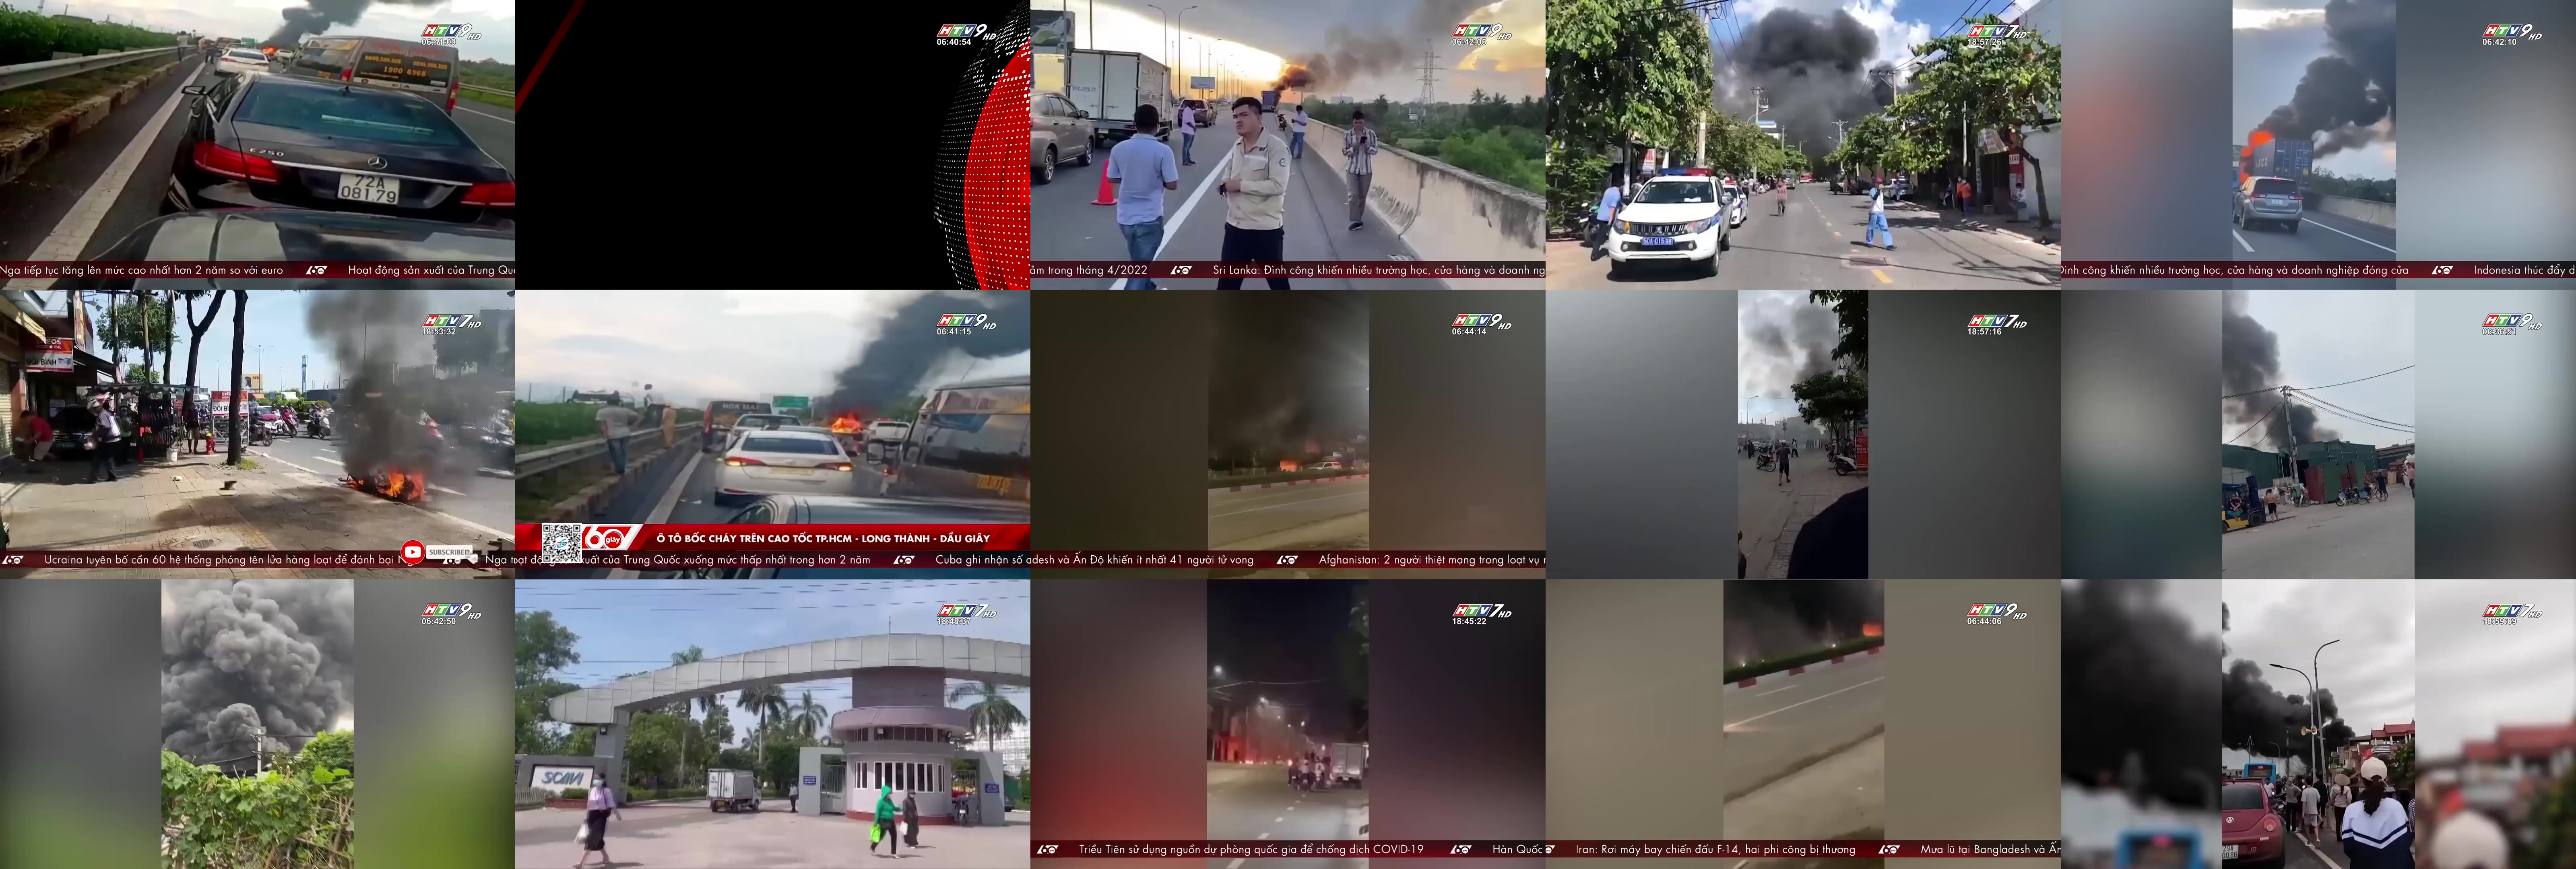

In [ ]:
visualize(read_image(work2("Một chiếc xe đang bị cháy trên đường. Lửa cháy rất to và có rất nhiều khói đen bốc lên. Sau đó có cảnh một người đang cầm điện thoại quay lại cảnh đó.")))